In [ ]:
from tarfile import data_filter

import pandas as pd
import numpy as np
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from dask.dataframe import read_csv
from matplotlib.pyplot import xticks
from pandas.core.interchange.dataframe_protocol import DataFrame
from ply.cpp import xrange
from pygments.lexer import bygroups

import volpy_func_lib as vp
import load_clean_lib
import table_lib
from pathlib import Path
from global_settings import *

from datetime import datetime
from volpy_func_lib import load_forward_price

In [275]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)

<module 'table_lib' from 'D:\\Professionelt\\Code\\volpy\\table_lib.py'>

# Create Data

In [ ]:
sum_df, od_raw = vp.load_analyze_create_swap(
    om_folder="i2s1_full_v2", 
    ticker_list=["SPX", "OEX"], 
    first_day=None, 
    last_day=None, 
    IV_type="om", 
    save_files = True
)

In [183]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)


IV_type = "om" # om = OptionMetrics IV, "bid"/"ask"/"mid" price
om_folder = "i2s1_full_v2" #i4s4_CW, SPX_short, SPX_full, i2s1_full_v2
ticker_list = None #["SPX", "OEX"]

# Load data and clean
od, returns_and_prices, od_raw = load_clean_lib.load_clean_and_prepare_od(om_folder = om_folder, tickers = ticker_list, first_day = None, last_day = None, IV_type = IV_type)

# Calculate results such as SW, RV ect.
summary_dly_df, od_rdy = load_clean_lib.create_summary_dly_df(od, returns_and_prices, first_day=None, last_day=None, n_grid=2000)
summary_dly_df = vp.interpolate_swaps_and_returns(summary_dly_df)
summary_dly_df = summary_dly_df.reset_index()

t_ was selected in global_settings.py
Data loaded


Processing Groups: 100%|██████████| 40730/40730 [00:23<00:00, 1750.75it/s]


### Skip at gemme od_rdy og od_raw hvis det skal gå hurtigt og man ikke er interesseret i options strategier (der skal bruge od_raw filen)

In [262]:
output_dir = load_clean_lib.volpy_output_dir(om_folder)
time_type = days_type()
summary_dly_df.to_csv(f"{output_dir}/{time_type}summary_dly.csv", index=False)
od_raw.to_csv(f"{output_dir}/{time_type}od_raw.csv", index=False)
# od_rdy.to_csv(f"{output_dir}/{time_type}od_rdy.csv", index=False)

# Start from here

In [263]:
profile = "Mads"
om_folder = "i2s1_full_v2"
input_dir = load_clean_lib.volpy_output_dir(om_folder)

sum_df = pd.read_csv(f"{input_dir}/{time_type}summary_dly.csv")
sum_df["date"] = pd.to_datetime(sum_df["date"])

In [264]:
table_lib.CarrWu2009_table_1(sum_df, print_latex = False)

,ticker,Starting_date,Ending_date,N,NK
2,SPX,04-Jan-1996,31-Aug-2023,6963,91.356958
1,NDX,04-Jan-1996,31-Aug-2023,6963,62.372110
0,AMZN,20-Nov-1997,31-Aug-2023,6439,56.855645


In [265]:
table_lib.CarrWu2009_table_2(sum_df, print_latex = False)

,ticker,Mean_RV,Std_RV,Auto_RV,Skew_RV,Kurt_RV,Mean_SW,Std_SW,Auto_SW,Skew_SW,Kurt_SW
2,SPX,3.759154,7.131686,0.993920,7.085852,61.817836,4.821457,5.116087,0.962548,4.959703,36.759604
1,NDX,7.901477,11.565394,0.992553,3.791352,18.220740,8.823611,8.997790,0.983107,2.320132,6.031977
0,AMZN,32.434173,45.713446,0.986179,2.522803,6.963856,33.674253,43.275896,0.990988,2.784986,9.343582


In [193]:
table_lib.CarrWu2009_table_3(sum_df, print_latex = False)

,ticker,Mean_diff,Std_diff,Auto_diff,Skew_diff,Kurt_diff,t_diff,Mean_ln,Std_ln,Auto_ln,Skew_ln,Kurt_ln,t_ln
2,SPX,-1.062304,5.428337,0.959700,7.842627,91.391808,-3.883735,-0.539959,0.621226,0.953760,0.889679,2.838382,-17.350824
1,NDX,-0.922134,7.248230,0.957398,4.469766,35.351980,-2.604480,-0.345882,0.554195,0.952697,0.608565,2.051511,-12.560360
0,AMZN,-2.890201,27.514070,0.938251,0.581125,12.666191,-2.290134,-0.291227,0.608413,0.929651,0.313888,1.024337,-9.773446


In [98]:
sum_df["RV_0_30-SW_0_30"] = sum_df["RV"] - sum_df["SW_0_30"]
table_lib.CarrWu2009_table_3_choose_stat(sum_df, print_latex = False, stat = "RV_0_30-SW_0_30")

,ticker,Mean,Std,Auto,Skew,Kurt,t
2,SPX,-1.048730,5.543912,0.889571,5.597785,72.157790,-4.106317
1,NDX,-1.011220,7.513488,0.887299,3.626128,30.739749,-2.919585
0,AMZN,-3.177542,27.235323,0.932657,0.438570,12.017753,-2.573485


In [99]:
table_lib.CarrWu2009_table_3_choose_stat(sum_df, print_latex = False, stat = "r_30_SW_day")

KeyError: ['r_30_SW_day']

# Not cleaned below

## Figures

In [200]:
import pandas as pd

alpha = 0.025

summary_table = (
    sum_df[sum_df["Active"]]
    .groupby('ticker')
    .agg(
        high_K_mean     = ('high #K',    'mean'),
        high_K_min      = ('high #K',    'min'),
        high_K_x_pct     = ('high #K',    lambda x: x.quantile(alpha)),
        high_K_max      = ('high #K',    'max'),
        
        low_K_mean      = ('low #K',     'mean'),
        low_K_min       = ('low #K',     'min'),
        low_K_x_pct      = ('low #K',     lambda x: x.quantile(alpha)),
        low_K_max       = ('low #K',     'max'),
        
        high_days_mean = ('high days', 'mean'),
        high_days_min  = ('high days', 'min'),
        high_days_x_pct = ('high days', lambda x: x.quantile(alpha)),
        high_days_max  = ('high days', 'max'),
        
        low_days_mean  = ('low days',  'mean'),
        low_days_min   = ('low days',  'min'),
        low_days_x_pct  = ('low days',  lambda x: x.quantile(alpha)),
        low_days_max   = ('low days',  'max'),
    )
    .reset_index()
)

In [201]:
summary_table

,ticker,high_K_mean,high_K_min,high_K_x_pct,high_K_max,low_K_mean,low_K_min,low_K_x_pct,low_K_max,high_days_mean,high_days_min,high_days_x_pct,high_days_max,low_days_mean,low_days_min,low_days_x_pct,low_days_max
0,AMZN,57.349278,3.0,6.0,352.0,56.362013,3.0,4.0,347.0,38.784594,22.0,22.0,96.0,19.128281,9.0,9.0,33.0
1,NDX,63.081861,6.0,19.0,397.0,61.662358,12.0,20.0,406.0,34.024846,22.0,22.0,91.0,19.358323,9.0,9.0,33.0
2,SPX,97.179951,8.0,18.0,431.0,85.533965,8.0,21.0,427.0,32.247738,22.0,22.0,55.0,19.312222,9.0,9.0,33.0


In [186]:
SPX_df = sum_df[sum_df["ticker"] == "SPX"].copy()

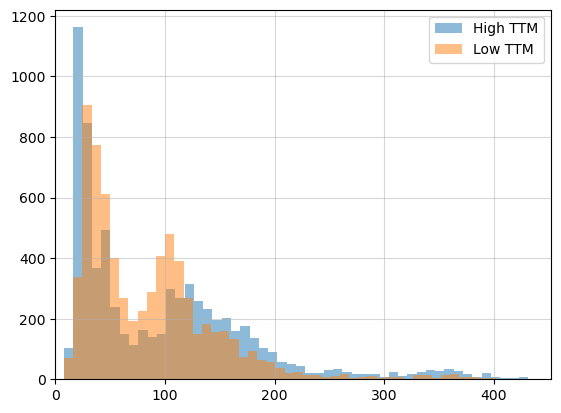

In [187]:
plt.hist(SPX_df["high #K"], label = "High TTM", alpha = 0.5, bins = 50)
plt.hist(SPX_df["low #K"], label = "Low TTM", alpha = 0.5, bins = 50)
plt.legend()
plt.xlim(0, None)
plt.grid(alpha=0.5)
plt.show()

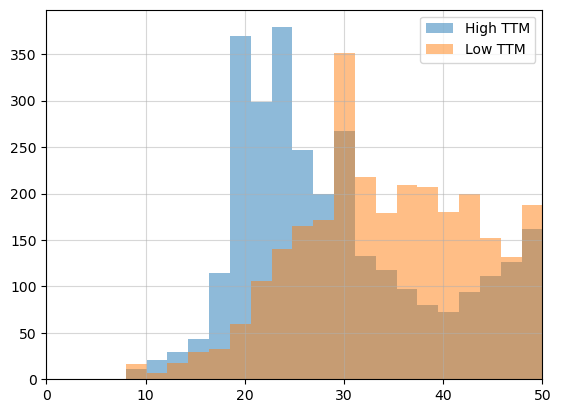

In [188]:
plt.hist(SPX_df[SPX_df["high #K"] <= 50]["high #K"], label = "High TTM", alpha = 0.5, bins = 20)
plt.hist(SPX_df[SPX_df["low #K"] <= 50]["low #K"], label = "Low TTM", alpha = 0.5, bins = 20)
plt.legend()
plt.xlim(0, 50)
plt.grid(alpha=0.5)
plt.show()

In [189]:
SPX_df

,ticker,date,index,#days,low days,high days,low #K,high #K,#K,low SW,...,RV_m30_0,SW_month,SW_month_ln_ret,SW_month_ln_ret_RF,SW_m1_29,SW_0_29,SW_sell,SW_buy,CF_30_SW_day,r_30_SW_day
6963,SPX,1996-01-04,6963,6.0,11.0,31.0,23.0,24.0,23.5,0.020016,...,NaN,NaN,NaN,NaN,NaN,0.018725,0.018241,NaN,NaN,NaN
6964,SPX,1996-01-05,6964,6.0,10.0,30.0,26.0,24.0,25.0,0.017681,...,NaN,NaN,NaN,NaN,0.018581,0.017152,0.016366,0.018581,-0.002216,NaN
6965,SPX,1996-01-08,6965,6.0,9.0,29.0,20.0,24.0,22.0,0.017218,...,NaN,NaN,NaN,NaN,0.017099,0.016549,0.015857,0.017099,-0.001241,NaN
6966,SPX,1996-01-09,6966,6.0,28.0,47.0,24.0,30.0,27.0,0.023619,...,NaN,NaN,NaN,NaN,0.016488,0.025788,0.027107,0.016488,0.010619,NaN
6967,SPX,1996-01-10,6967,6.0,27.0,46.0,25.0,29.0,27.0,0.024450,...,NaN,NaN,NaN,NaN,0.025517,0.025655,0.028321,0.025517,0.002805,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13921,SPX,2023-08-25,13921,42.0,21.0,24.0,47.0,352.0,199.5,0.023300,...,0.007996,-0.008665,-0.734117,-0.734317,0.026864,0.022676,0.022138,0.026864,-0.004726,-0.194536
13922,SPX,2023-08-28,13922,42.0,21.0,23.0,46.0,349.0,197.5,0.022123,...,0.008380,-0.009584,-0.762505,-0.762705,0.023300,0.021491,0.020938,0.023300,-0.002362,-0.095430
13923,SPX,2023-08-29,13923,42.0,21.0,22.0,48.0,352.0,200.0,0.020672,...,0.009803,-0.008118,-0.603285,-0.603485,0.022123,0.020053,0.021624,0.022123,-0.000499,-0.020077
13924,SPX,2023-08-30,13924,42.0,21.0,22.0,352.0,113.0,232.5,0.019415,...,0.009880,-0.009396,-0.668335,-0.668535,0.020672,0.020720,0.019909,0.020672,-0.000762,-0.030369


In [274]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [268]:
# ensure your DataFrame is datetime‑indexed
SPX_df['date'] = pd.to_datetime(SPX_df['date'])
SPX_df.set_index('date', inplace=True)

KeyError: 'date'

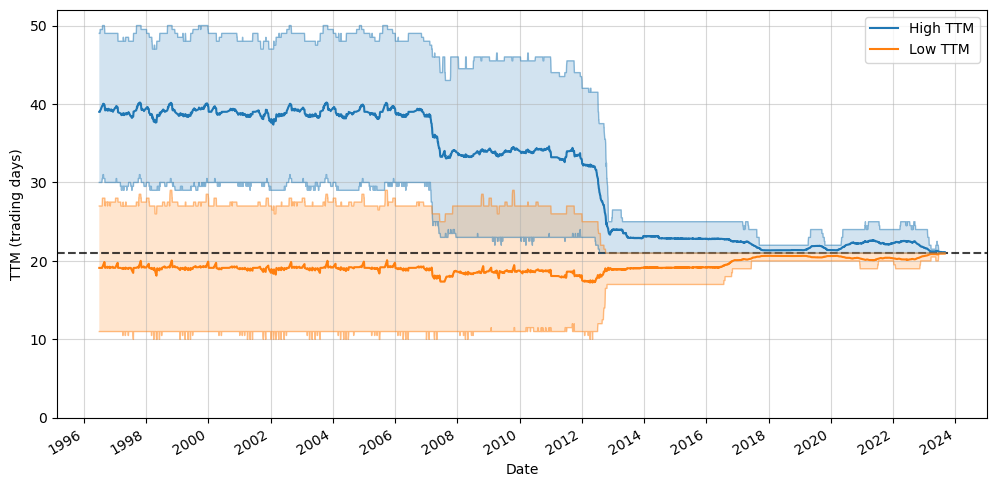

In [271]:
vp.plot_timeseries_with_pct(alpha = 0.1, var = "days", var_name = "TTM (trading days)")

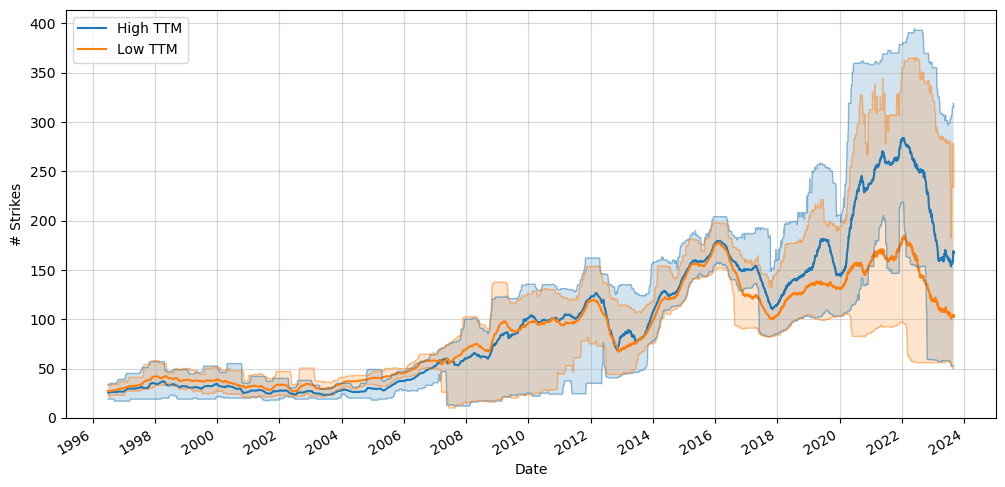

In [272]:
plot_timeseries_with_pct(alpha = 0.1, var = "#K", var_name = "# Strikes")

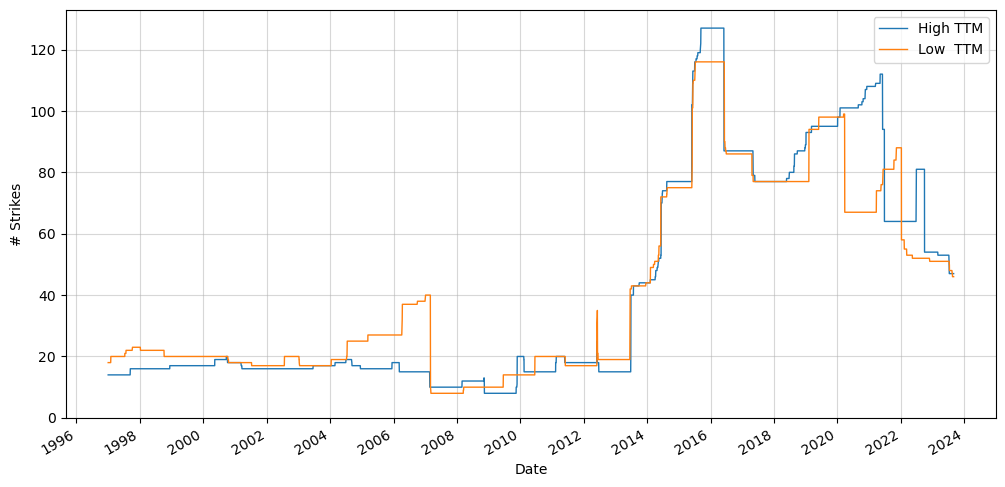

In [273]:
# define your window length
window_size = 21 * 12  # e.g. 252 days
alpha = 1 / window_size

# helper to average the bottom 5% of values in an array
def bottom_5pct_avg(x):
    k = max(int(len(x) * alpha), 1)          # at least one value
    # partition so first k entries are the k smallest (unsorted)
    smallest_k = np.partition(x, k - 1)[:k]
    return smallest_k.mean()

# apply rolling window with that custom function
rolling_bot5_high = SPX_df['high #K'] \
    .rolling(window=window_size, min_periods=window_size) \
    .apply(bottom_5pct_avg, raw=True)
rolling_bot5_low = SPX_df['low #K'] \
    .rolling(window=window_size, min_periods=window_size) \
    .apply(bottom_5pct_avg, raw=True)

# drop the initial NaNs (first window_size‑1 days)
rolling_bot5_high = rolling_bot5_high.dropna()
rolling_bot5_low  = rolling_bot5_low.dropna()

# plot with true dates on x-axis (every other year)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rolling_bot5_high.index, rolling_bot5_high, label='High TTM', linewidth=1)
ax.plot(rolling_bot5_low.index,  rolling_bot5_low,  label='Low  TTM', linewidth=1)

# format x-axis: a tick every other year
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()  # rotate labels

ax.legend()
# ax.set_title(f'Rolling average of the lowest {alpha*100:.1f}% of #K over the past year')
ax.set_xlabel('Date')
ax.set_ylabel('# Strikes')
ax.grid(alpha=0.5)
ax.set_ylim(0, None)

plt.show()

## Other

In [47]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)

<module 'table_lib' from 'D:\\Professionelt\\Code\\volpy\\table_lib.py'>

In [20]:
def one_ticker(summary_dly_df, ticker = "SPX"):
    df_ticker = summary_dly_df[summary_dly_df["ticker"] == ticker].reset_index(drop = True)
    # df_ticker = df_ticker[df_ticker["SW_day_return"].isna() == False]
    return df_ticker

In [21]:
df = one_ticker(summary_dly_df, "SPX")

In [7]:
max(np.maximum(df["SW_sell"], 0.001))

1.173559018807811

In [8]:
min(np.maximum(df["SW_sell"], 0.001) / np.maximum(df["SW_buy"], 0.001) - 1)

-0.9615923636030196

In [16]:
np.cumprod(2 - np.maximum(df["SW_sell"], 0.001) / np.maximum(df["SW_buy"], 0.001))

1        1.086992e+00
2        1.184104e+00
3        5.494757e-01
4        5.735089e-01
5        7.100811e-01
            ...      
6958     6.303410e-99
6959     7.004216e-99
6960     6.039512e-99
6961     1.003207e-98
6962   -3.645868e-100
Length: 6962, dtype: float64

In [45]:
summary_dly_df["ticker"].unique()

array(['NDX', 'SPX', 'AMZN'], dtype=object)

In [17]:
df = one_ticker(summary_dly_df, "NDX")

NameError: name 'one_ticker' is not defined

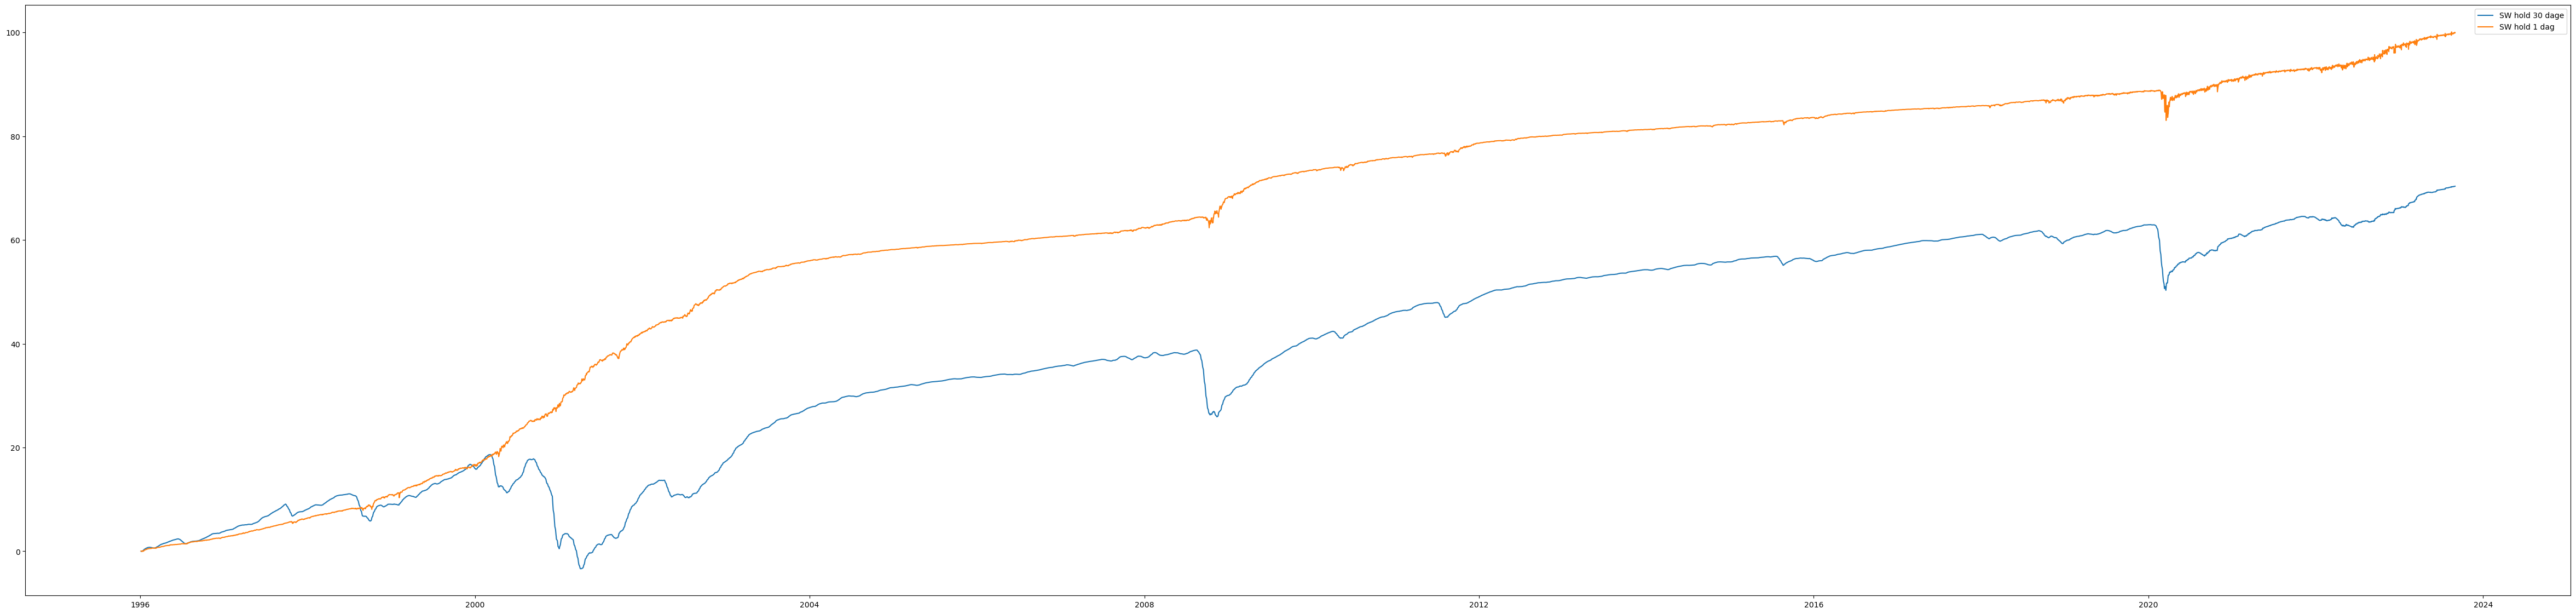

In [67]:
plt.figure(figsize=(60, 14))
plt.plot( df["date"] , np.cumsum((df["SW_0_30"] - df["RV"] )) , label = "SW hold 30 dage")
plt.plot( df["date"] , -5*np.cumsum(df["SW_day"]), label = "SW hold 1 dag")
plt.legend()
plt.show()

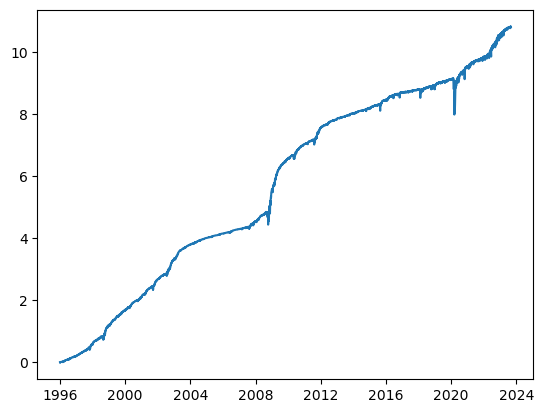

In [21]:
plt.plot( df["date"] , np.cumsum(-df["SW_day"]))
plt.show()

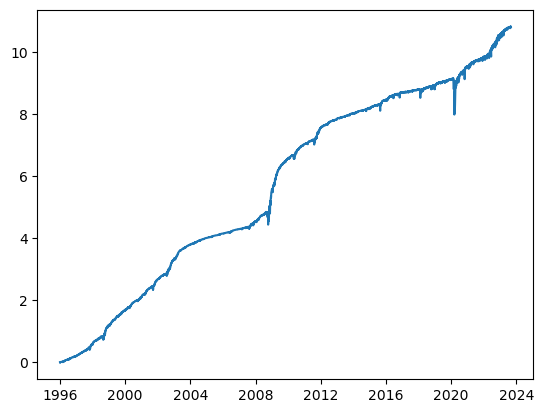

In [18]:
plt.plot( df["date"] , -np.cumsum(df["SW_day"]))
plt.show()

In [ ]:
plt.plot( df["date"] , df["SW_day"])
plt.show()

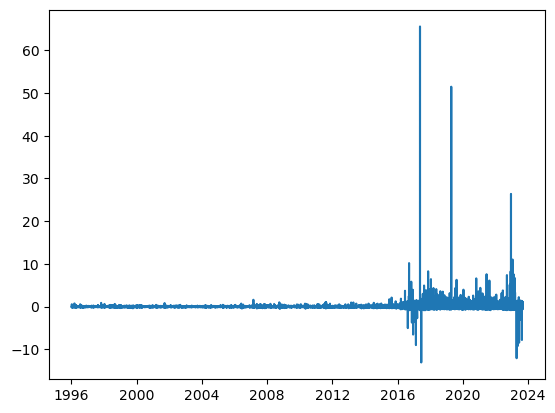

In [20]:
plt.plot( df["date"] , df["SW_day_return"])
plt.show()

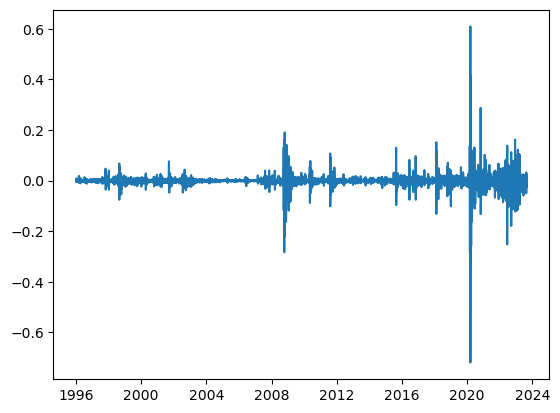

In [19]:
plt.plot( df["date"] , df["SW_day"])
plt.show()

In [37]:
SPX

,ticker,date,#days,low days,high days,low #K,high #K,#K,low SW,high SW,...,RV,open,squared_return,SW_0_30,SW_m1_29,SW_0_29,SW_day,SW_day_return,SW_sell,SW_buy
1,SPX,1996-01-05,6.0,15.0,43.0,26.0,24.0,25.0,0.017910,0.016568,...,0.015841,617.70,0.000003,0.016880,0.017860,0.016869,-0.001554,-0.086992,0.016307,0.017860
2,SPX,1996-01-08,6.0,12.0,40.0,20.0,24.0,22.0,0.016703,0.015776,...,0.016645,616.71,0.000008,0.015908,0.016880,0.015901,-0.001508,-0.089340,0.015372,0.016880
3,SPX,1996-01-09,6.0,11.0,39.0,23.0,24.0,23.5,0.039962,0.023438,...,0.016908,618.46,0.000212,0.025385,0.015908,0.025269,0.008526,0.535957,0.024434,0.015908
4,SPX,1996-01-10,6.0,10.0,38.0,21.0,25.0,23.0,0.033677,0.024267,...,0.015500,609.45,0.000324,0.025163,0.025385,0.025101,-0.001110,-0.043738,0.024275,0.025385
5,SPX,1996-01-11,6.0,9.0,37.0,17.0,24.0,20.5,0.019887,0.019826,...,0.011791,598.48,0.000049,0.019830,0.025163,0.019830,-0.005992,-0.238134,0.019171,0.025163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,SPX,2023-08-25,42.0,4.0,5.0,119.0,126.0,122.5,0.013806,0.015857,...,0.015730,4389.38,0.000045,0.022693,0.024453,0.021161,-0.003996,-0.163412,0.020457,0.024453
6959,SPX,2023-08-28,42.0,2.0,3.0,112.0,182.0,147.0,0.019612,0.020260,...,0.016819,4426.03,0.000039,0.021428,0.022693,0.020864,-0.002523,-0.111179,0.020170,0.022693
6960,SPX,2023-08-29,42.0,2.0,3.0,189.0,175.0,182.0,0.022140,0.023731,...,0.019129,4432.75,0.000210,0.026595,0.021428,0.025213,0.002951,0.137732,0.024379,0.021428
6961,SPX,2023-08-30,42.0,2.0,6.0,160.0,136.0,148.0,0.022032,0.011503,...,0.002173,4500.34,0.000015,0.007291,0.026595,0.009324,-0.017581,-0.661073,0.009014,0.026595


In [158]:
SPX["SW_buy"]

1       0.017484
2       0.016494
3       0.015528
4       0.025016
5       0.024791
          ...   
6958    0.024387
6959    0.022696
6960    0.021470
6961    0.026605
6962    0.007231
Name: SW_buy, Length: 6962, dtype: float64

In [38]:
SPX["SW_sell"].min()

-0.00028882011915477905

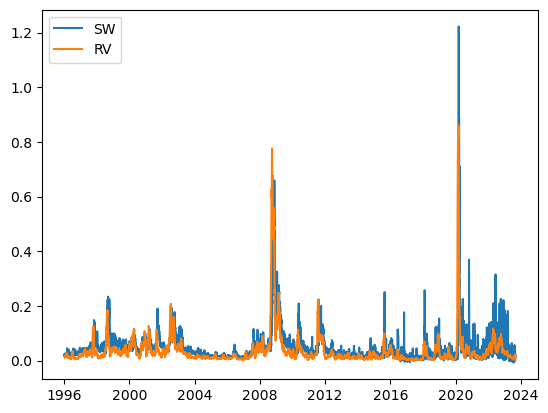

In [39]:
plt.plot(SPX["date"], SPX["SW_0_30"], label = "SW")
plt.plot(SPX["date"], SPX["RV"], label = "RV")
plt.legend()
plt.show()

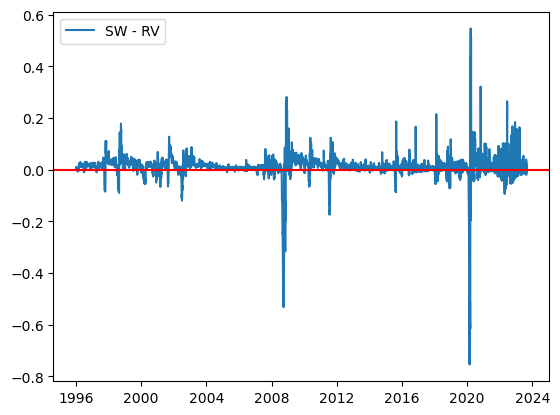

In [40]:
plt.plot(SPX["date"], SPX["SW_0_30"] - SPX["RV"], label = "SW - RV")
plt.legend()
plt.axhline(y=0, color = "red")
plt.show()

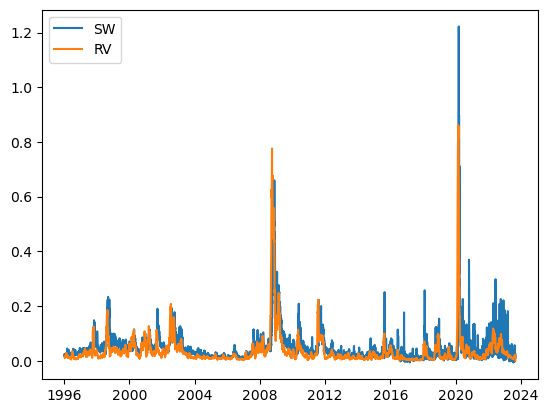

In [165]:
plt.plot(SPX["date"], SPX["SW_0_30"], label = "SW")
plt.plot(SPX["date"], SPX["RV"], label = "RV")
plt.legend()
plt.show()

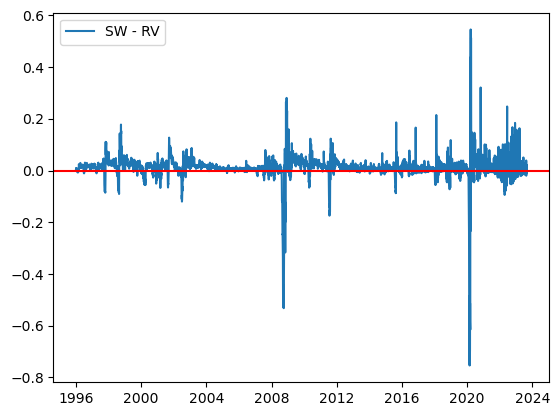

In [171]:
plt.plot(SPX["date"], SPX["SW_0_30"] - SPX["RV"], label = "SW - RV")
plt.legend()
plt.axhline(y=0, color = "red")
plt.show()

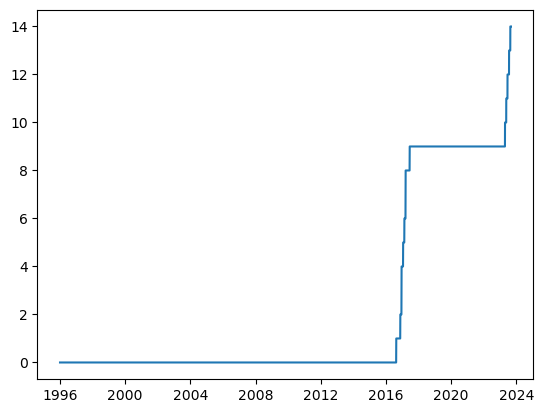

In [41]:
plt.plot(SPX["date"], np.cumsum(SPX["SW_buy"]<0))

In [43]:
min(SPX["SW_sell"]/SPX["SW_buy"]-1)

-13.100232650793211

In [44]:
max(SPX["SW_sell"]/SPX["SW_buy"]-1)

65.5856150940696

In [45]:
np.mean(SPX["SW_sell"]/SPX["SW_buy"]-1)

0.049239789338758916